# Optimized Kalman Filter: Analysis on Lidar Data

In [1]:
# Auto reload
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats

import os
import pickle as pkl
from collections import Counter
import gc
import cv2

import torch
import torch.nn.functional as F

import utils
import Driving.lidar_trainer as LD
import OKF

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:90% !important; }</style>"))
np.set_printoptions(precision=3)
np.set_printoptions(linewidth=150)
np.set_printoptions(suppress=True)
torch.set_printoptions(linewidth=150)

# Generate lidar data

In [3]:
%time X, Z = LD.simulate_data(2000, noise_r=1, noise_t=0.8*np.pi/180, save='lidar_noise1')
type(X), len(X), type(X[0]), X[0].shape, type(Z), len(Z), type(Z[0]), Z[0].shape

CPU times: user 3.07 s, sys: 12.7 ms, total: 3.08 s
Wall time: 3.07 s


(list,
 2000,
 pandas.core.frame.DataFrame,
 (36, 4),
 list,
 2000,
 pandas.core.frame.DataFrame,
 (36, 2))

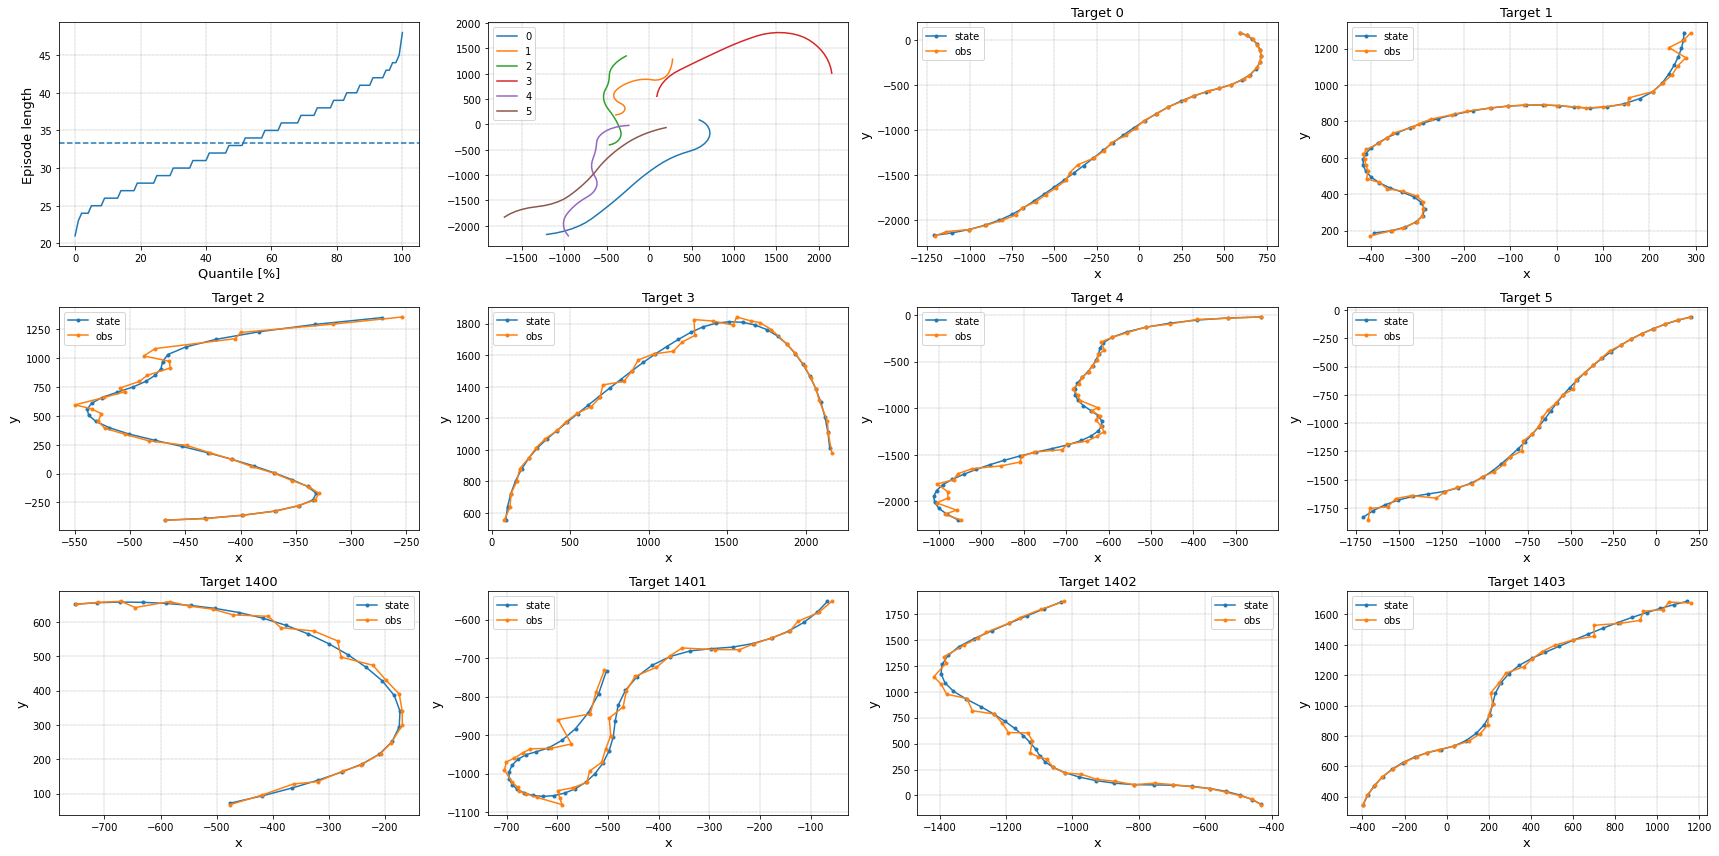

In [29]:
axs = utils.Axes(12,4, (6,4))
utils.plot_quantiles([len(x) for x in X], axs[0], showmeans=True)
axs.labs(0, 'Quantile [%]', 'Episode length');

ax = axs[1]
for i in range(6):
    ax.plot(X[i]['x'], X[i]['y'], '-', label=str(i))
ax.legend()

for a in range(6):
    ax = axs[2+a]
    ax.plot(X[a]['x'], X[a]['y'], '.-', label='state')
    ax.plot(Z[a]['zx'], Z[a]['zy'], '.-', label='obs')
    axs.labs(2+a, 'x', 'y', f'Target {a}')
    ax.legend();

ntrain = int(0.7 * len(X))
for a in range(4):
    ax = axs[8+a]
    ax.plot(X[ntrain+a]['x'], X[ntrain+a]['y'], '.-', label='state')
    ax.plot(Z[ntrain+a]['zx'], Z[ntrain+a]['zy'], '.-', label='obs')
    axs.labs(8+a, 'x', 'y', f'Target {ntrain+a}')
    ax.legend();

plt.tight_layout()
plt.savefig('lidar_trajectories.png', bbox_inches='tight')

## Split train/test

In [5]:
%%time
Xtrain, Ytrain = LD.get_trainable_data(Z[:ntrain], X[:ntrain])
Xtest, Ytest = LD.get_trainable_data(Z[ntrain:], X[ntrain:])
len(Ytrain), Ytrain[0].shape

CPU times: user 23.5 ms, sys: 460 µs, total: 24 ms
Wall time: 26.3 ms


(1400, (36, 4))

# Create models

In [11]:
lidar_args = dict(
    dim_x = 4,
    dim_z = 2,
    framework = 'lidar_noise1',
    z2x = LD.z2x,
    loss_fun = LD.loss_fun(v=False),
    F = LD.get_F(),
    H = LD.get_H(),
)
models = [
    OKF.OKF(title='KF', optimize=False, **lidar_args),
    OKF.OKF(title='OKF', optimize=True, **lidar_args)
]

# Train

In [12]:
%%time
r1, rv1 = OKF.train(models[0], Xtrain, Ytrain)
rv1

CPU times: user 2.96 s, sys: 0 ns, total: 2.96 s
Wall time: 2.84 s


,model,target,t,SE,AE,loss
0,KF,0,0,0.000000,0.000000,0.000000
1,KF,0,1,1575.340553,39.690560,1575.340553
2,KF,0,2,414.677879,20.363641,414.677879
3,KF,0,3,354.022063,18.815474,354.022063
4,KF,0,4,696.660513,26.394327,696.660513
...,...,...,...,...,...,...
6953,KF,209,33,33.844187,5.817576,33.844187
6954,KF,209,34,104.782612,10.236338,104.782612
6955,KF,209,35,53.277810,7.299165,53.277810
6956,KF,209,36,11.751455,3.428039,11.751455


In [13]:
%%time
r2, rv2 = OKF.train(models[1], Xtrain, Ytrain, n_epochs=1)
r2


Training OKF:
samples=1190(t)+210(v)=1400; batch_size=10; iterations=1(e)x119(b)=119.
	[OKF] 01.0001/01.0119:	train_RMSE=32.00, valid_RMSE=33.11   |   2 [s]
	[OKF] 01.0031/01.0119:	train_RMSE=31.86, valid_RMSE=30.63   |   10 [s]
	[OKF] 01.0061/01.0119:	train_RMSE=30.28, valid_RMSE=29.93   |   17 [s]
	[OKF] 01.0091/01.0119:	train_RMSE=27.97, valid_RMSE=29.90   |   26 [s]
	[OKF] 01.0119/01.0119:	train_RMSE=34.62, valid_RMSE=29.90   |   34 [s]
[OKF] Epoch 1/1 (34 [s])
[OKF] Training done (34 [s])
	best valid loss: 894;	no early stopping:	1 epochs, 119 batches, 119 total iterations.
CPU times: user 35.8 s, sys: 35.6 ms, total: 35.8 s
Wall time: 35.6 s


,model,t,group,loss,RMSE
0,OKF,1,train,1024.020359,32.000318
1,OKF,2,train,931.446602,30.519610
2,OKF,3,train,1055.415751,32.487163
3,OKF,4,train,969.090608,31.130220
4,OKF,5,train,1362.805277,36.916193
...,...,...,...,...,...
0,OKF,1,valid,1096.281646,33.110144
1,OKF,31,valid,937.924419,30.625552
2,OKF,61,valid,896.026186,29.933696
3,OKF,91,valid,893.814311,29.896727


### Training summary (OKF only):

<AxesSubplot:xlabel='t', ylabel='RMSE'>

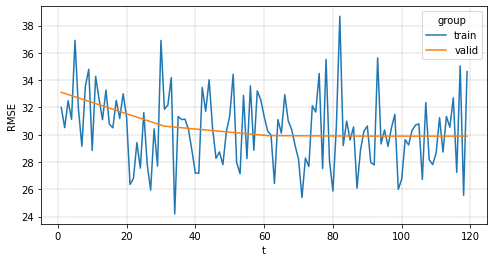

In [14]:
ax = utils.Axes(1, 1, axsize=(8,4))[0]
sns.lineplot(data=r2, x='t', hue='group', y='RMSE', ax=ax)

### Validation summary:

In [15]:
rv = pd.concat((rv1,rv2))
rv = rv[rv.t>0]
print('Average losses:')
print(rv.groupby('model').apply(lambda d:d.loss.mean()))
rv

Average losses:
model
KF     1138.685454
OKF     921.630109
dtype: float64


,model,target,t,SE,AE,loss
1,KF,0,1,1575.340553,39.690560,1575.340553
2,KF,0,2,414.677879,20.363641,414.677879
3,KF,0,3,354.022063,18.815474,354.022063
4,KF,0,4,696.660513,26.394327,696.660513
5,KF,0,5,958.901311,30.966132,958.901311
...,...,...,...,...,...,...
6953,OKF,209,33,7.492460,2.737236,7.492460
6954,OKF,209,34,202.419756,14.227430,202.419756
6955,OKF,209,35,52.065528,7.215645,52.065528
6956,OKF,209,36,52.449861,7.242228,52.449861


CPU times: user 1.15 s, sys: 393 ms, total: 1.54 s
Wall time: 1.11 s


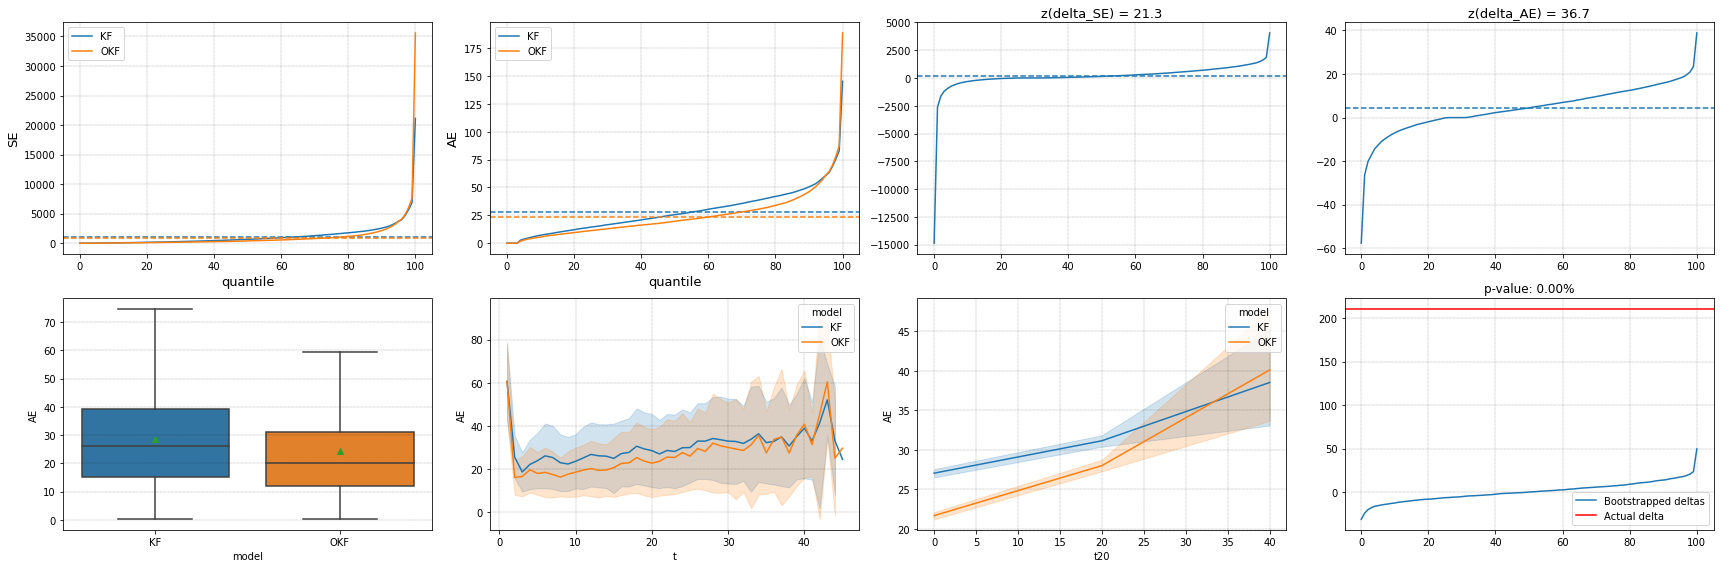

In [16]:
%%time
axs = utils.Axes(8,4,axsize=(6,4))
a = 0

utils.plot_quantiles(rv1.SE.values, showmeans=True, ax=axs[a], label='KF');
utils.plot_quantiles(rv2.SE.values, showmeans=True, ax=axs[a], label='OKF');
axs[a].legend()
# axs[a].set_ylim((0,2))
axs.labs(a, 'quantile', 'SE')
a += 1

utils.plot_quantiles(rv1.AE.values, showmeans=True, ax=axs[a], label='KF');
utils.plot_quantiles(rv2.AE.values, showmeans=True, ax=axs[a], label='OKF');
axs[a].legend()
# axs[a].set_ylim((0,2))
axs.labs(a, 'quantile', 'AE')
a += 1

delta = rv1.loss.values-rv2.loss.values
utils.plot_quantiles(delta, showmeans=True, ax=axs[a]);
# axs[a].set_ylim((-1,1))
axs.labs(a, title=f'z(delta_SE) = {np.mean(delta)/np.std(delta)*np.sqrt(len(delta)):.1f}')
a += 1

delta = rv1.AE.values-rv2.AE.values
utils.plot_quantiles(delta, showmeans=True, ax=axs[a]);
# axs[a].set_ylim((-1,1))
axs.labs(a, title=f'z(delta_AE) = {np.mean(delta)/np.std(delta)*np.sqrt(len(delta)):.1f}')
a += 1

sns.boxplot(data=rv, x='model', y='AE', showmeans=True, showfliers=False, ax=axs[a])
a += 1

sns.lineplot(data=rv, x='t', hue='model', y='AE', ci='sd', ax=axs[a]);
a += 1

rv['t20'] = rv.t.values//20 * 20
sns.lineplot(data=rv, x='t20', hue='model', y='AE', ax=axs[a]);
a += 1

B = 1000
ax = axs[a]
delta = rv1.loss.values-rv2.loss.values
mean0 = np.mean(delta)
means = [np.mean(np.sign(np.random.rand(len(delta))-0.5) * delta) for _ in range(B)]
pval = np.mean(means>=mean0)
utils.plot_quantiles(means, label='Bootstrapped deltas', ax=ax)
ax.axhline(mean0, color='r', label='Actual delta')
ax.legend()
ax.set_title(f'p-value: {100*pval:.2f}%')
a += 1

plt.tight_layout();

### Q & R comparison:

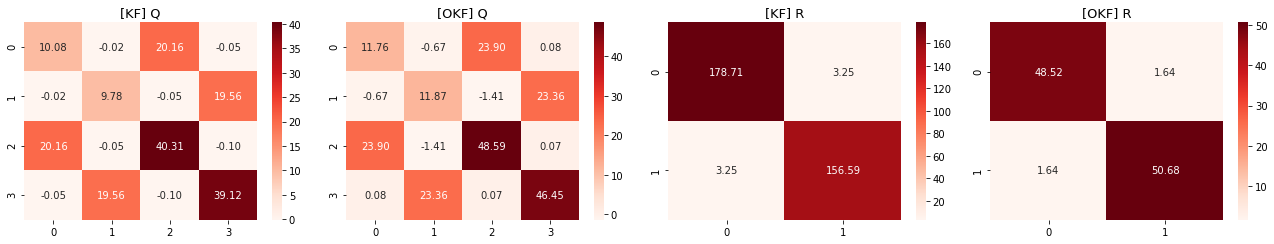

In [17]:
axs = utils.Axes(2*len(models),4,axsize=(4.5,3.5))
a = 0
for m in models:
    tit = m.title
    Q = m.get_SPD(m.Q_D, m.Q_L).detach().numpy()
    R = m.get_SPD(m.R_D, m.R_L).detach().numpy()
    sns.heatmap(Q, annot=True, fmt='.2f', cmap="Reds", ax=axs[a])
    sns.heatmap(R, annot=True, fmt='.2f', cmap="Reds", ax=axs[a+len(models)])
    axs.labs(a, title=f'[{tit}] Q')
    axs.labs(a+len(models), title=f'[{tit}] R')
    a += 1

plt.tight_layout();

# Test

In [18]:
for m in models:
    m.load_model()

In [19]:
%%time
rt = pd.DataFrame()
for m in models:
    rt = pd.concat((rt, OKF.test_model(m, Xtest, Ytest, detailed=True, loss_after_pred=False)))
rt = rt[rt.t>0]
rt

CPU times: user 10.6 s, sys: 23.1 ms, total: 10.6 s
Wall time: 10.6 s


,model,target,t,SE,AE,loss
1,KF,0,1,55.981392,7.482071,55.981392
2,KF,0,2,91.993715,9.591335,91.993715
3,KF,0,3,2.817253,1.678468,2.817253
4,KF,0,4,28.832085,5.369552,28.832085
5,KF,0,5,23.515604,4.849289,23.515604
...,...,...,...,...,...,...
20308,OKF,599,27,235.562390,15.348042,235.562390
20309,OKF,599,28,111.106746,10.540718,111.106746
20310,OKF,599,29,130.763380,11.435182,130.763380
20311,OKF,599,30,91.980418,9.590642,91.980418


In [20]:
rt.to_pickle('data/lidar_results1.pkl')
# rt = pd.read_pickle('data/lidar_results1.pkl')

CPU times: user 1.32 s, sys: 429 ms, total: 1.75 s
Wall time: 1.23 s


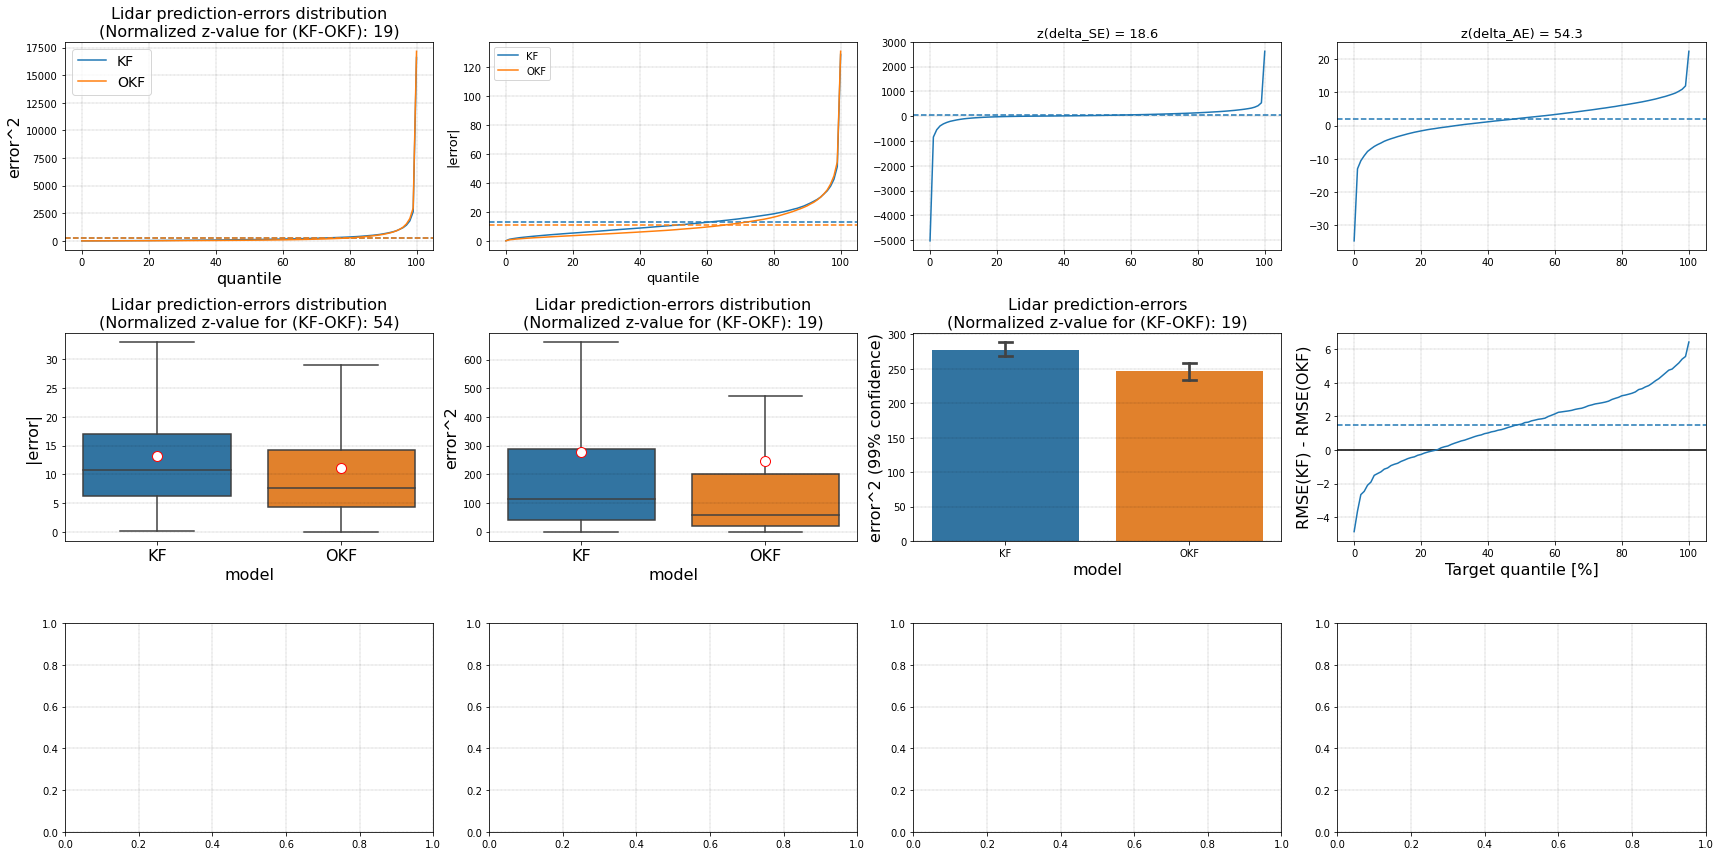

In [21]:
%%time
DETAILED = False
rt1 = rt[rt.model=='KF']
rt2 = rt[rt.model=='OKF']
axs = utils.Axes(12,4,axsize=(6,4))
a = 0

utils.plot_quantiles(rt1.SE.values, showmeans=True, ax=axs[a], label='KF');
utils.plot_quantiles(rt2.SE.values, showmeans=True, ax=axs[a], label='OKF');
axs[a].legend(fontsize=14)
# axs[a].set_ylim((0,2))
delta = rt1.SE.values-rt2.SE.values
z = np.mean(delta)/np.std(delta)*np.sqrt(len(delta))
axs.labs(a, 'quantile', 'error^2', f'Lidar prediction-errors distribution\n(Normalized z-value for (KF-OKF): {z:.0f})', fontsize=16)
# print(rt2.SE.values.mean()/rt1.SE.values.mean())
a += 1

utils.plot_quantiles(rt1.AE.values, showmeans=True, ax=axs[a], label='KF');
utils.plot_quantiles(rt2.AE.values, showmeans=True, ax=axs[a], label='OKF');
axs[a].legend()
# axs[a].set_ylim((0,2))
axs.labs(a, 'quantile', '|error|')
a += 1

delta = rt1.loss.values-rt2.loss.values
utils.plot_quantiles(delta, showmeans=True, ax=axs[a]);
# axs[a].set_ylim((-1,1))
axs.labs(a, title=f'z(delta_SE) = {np.mean(delta)/np.std(delta)*np.sqrt(len(delta)):.1f}')
a += 1

delta = rt1.AE.values-rt2.AE.values
utils.plot_quantiles(delta, showmeans=True, ax=axs[a]);
# axs[a].set_ylim((-1,1))
axs.labs(a, title=f'z(delta_AE) = {np.mean(delta)/np.std(delta)*np.sqrt(len(delta)):.1f}')
a += 1

sns.boxplot(data=rt, x='model', y='AE', showmeans=True, showfliers=False, ax=axs[a], meanprops=dict(marker='o',markerfacecolor='w',markeredgecolor='r',markersize=10))
delta = rt1.AE.values-rt2.AE.values
z = np.mean(delta)/np.std(delta)*np.sqrt(len(delta))
p = stats.norm.sf(z)
axs.labs(a, 'model', '|error|', f'Lidar prediction-errors distribution\n(Normalized z-value for (KF-OKF): {z:.0f})', fontsize=16)
axs[a].set_xticklabels(axs[a].get_xticklabels(), fontsize=16)
a += 1

sns.boxplot(data=rt, x='model', y='SE', showmeans=True, showfliers=False, ax=axs[a], meanprops=dict(marker='o',markerfacecolor='w',markeredgecolor='r',markersize=10))
delta = rt1.loss.values-rt2.loss.values
z = np.mean(delta)/np.std(delta)*np.sqrt(len(delta))
p = stats.norm.sf(z)
axs.labs(a, 'model', 'error^2', f'Lidar prediction-errors distribution\n(Normalized z-value for (KF-OKF): {z:.0f})', fontsize=16)
axs[a].set_xticklabels(axs[a].get_xticklabels(), fontsize=16)
a += 1

sns.barplot(data=rt, x='model', y='loss', capsize=.07, ci=99, ax=axs[a])
axs.labs(a, 'model', 'error^2 (99% confidence)', f'Lidar prediction-errors\n(Normalized z-value for (KF-OKF): {z:.0f})', fontsize=16)
a += 1

rmse_advantage = (rt1.groupby('target').apply(lambda d:np.sqrt(d.SE.mean())) - rt2.groupby('target').apply(lambda d:np.sqrt(d.SE.mean()))).values
axs[a].axhline(0, color='k')
utils.plot_quantiles(rmse_advantage, axs[a], showmeans=True)
axs.labs(a, 'Target quantile [%]', 'RMSE(KF) - RMSE(OKF)', fontsize=16)
a += 1

if DETAILED:

    sns.violinplot(data=rt, x='model', y='AE', showmeans=True, showfliers=False, ax=axs[a])
    delta = rt1.AE.values-rt2.AE.values
    z = np.mean(delta)/np.std(delta)*np.sqrt(len(delta))
    p = stats.norm.sf(z)
    axs.labs(a, 'model', '|error|', f'Lidar prediction-errors distribution\n(Normalized z-value for (KF-OKF): {z:.0f})', fontsize=16)
    axs[a].set_xticklabels(axs[a].get_xticklabels(), fontsize=16)
    axs[a].set_ylim((0,3))
    a += 1

    sns.violinplot(data=rt, x='model', y='SE', showmeans=True, showfliers=False, ax=axs[a])
    delta = rt1.loss.values-rt2.loss.values
    z = np.mean(delta)/np.std(delta)*np.sqrt(len(delta))
    p = stats.norm.sf(z)
    axs.labs(a, 'model', 'error^2', f'Lidar prediction-errors distribution\n(Normalized z-value for (KF-OKF): {z:.0f})', fontsize=16)
    axs[a].set_xticklabels(axs[a].get_xticklabels(), fontsize=16)
    axs[a].set_ylim((0,3))
    a += 1
    
    sns.lineplot(data=rt, x='t', hue='model', y='AE', ci='sd', ax=axs[a]);
    a += 1

    rt['t20'] = rt.t.values//20 * 20
    sns.lineplot(data=rt, x='t20', hue='model', y='AE', ax=axs[a]);
    a += 1

    B = 1000
    ax = axs[a]
    delta = rt1.loss.values-rt2.loss.values
    mean0 = np.mean(delta)
    means = [np.mean(np.sign(np.random.rand(len(delta))-0.5) * delta) for _ in range(B)]
    pval = np.mean(means>=mean0)
    utils.plot_quantiles(means, label='Bootstrapped deltas', ax=ax)
    ax.axhline(mean0, color='r', label='Actual delta')
    ax.legend()
    ax.set_title(f'p-value: {100*pval:.2f}%')
    a += 1

plt.tight_layout();

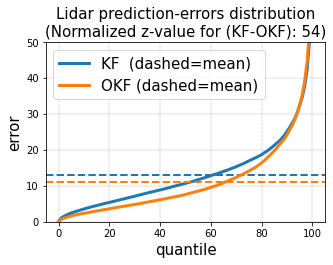

In [22]:
axs = utils.Axes(1,1,axsize=(5,3.3))
utils.plot_quantiles(rt1.AE.values, showmeans=True, ax=axs[a], label='KF  (dashed=mean)', linewidth=3, means_args=dict(linewidth=2));
utils.plot_quantiles(rt2.AE.values, showmeans=True, ax=axs[a], label='OKF (dashed=mean)', linewidth=3, means_args=dict(linewidth=2));
axs[a].legend(fontsize=15)
axs[a].set_ylim((0,50))
delta = rt1.AE.values-rt2.AE.values
z = np.mean(delta)/np.std(delta)*np.sqrt(len(delta))
axs.labs(a, 'quantile', 'error', f'Lidar prediction-errors distribution\n(Normalized z-value for (KF-OKF): {z:.0f})', fontsize=15)
plt.savefig('lidar_SE.png', bbox_inches='tight')

In [23]:
100*(1-rt2.AE.mean()/rt1.AE.mean())

14.9470845007031

### Tracking visualization

0 [137  70]
1 [167 134]
2 [337 285]
3 [239 209]
4 [251 171]
5 [255 226]
6 [139  79]
7 [386 542]
CPU times: user 1.58 s, sys: 44 ms, total: 1.63 s
Wall time: 1.63 s


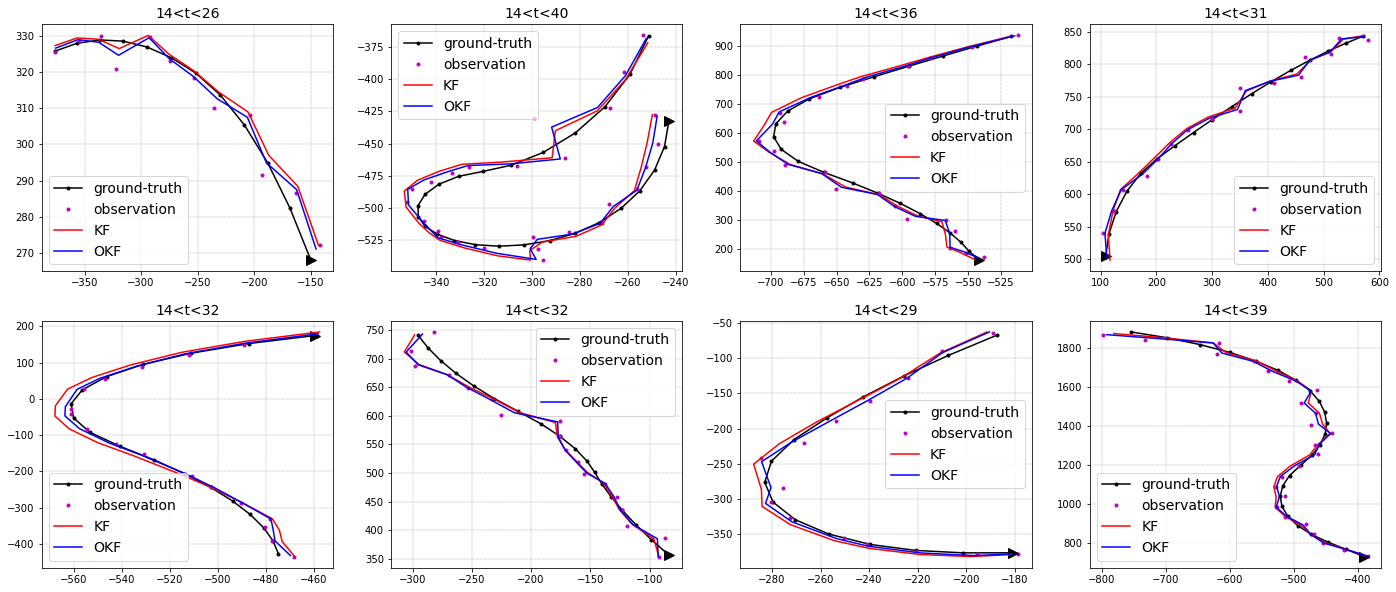

In [28]:
%%time

offset = 14
n = 8
axs = utils.Axes(8,4,axsize=(6,5))
colors = ['r','b']
preds = {}
for itar in range(8):
    ax = axs[itar]
    print(itar, rt[rt.target==itar].groupby('model').apply(lambda d:d.loss.mean()).values.astype(int))
    preds[itar] = []
    XX = Xtest[itar]
    ax.plot(Ytest[itar][offset:,0]/2,Ytest[itar][offset:,1]/2,'k.-', label='ground-truth')
    ax.plot(Xtest[itar][offset:,0]/2,Xtest[itar][offset:,1]/2,'m.', label='observation')
    ax.plot(Ytest[itar][offset:offset+1,0]/2,Ytest[itar][offset:offset+1,1]/2,'k>',markersize=10)
    for i,m in enumerate(models):
        preds[itar].append([])
        m.init_state()
        for t in range(len(XX)):
            x = XX[t,:]
            m.predict()
#             if t>0:
#                 preds[itar][i].append(m.x.detach().numpy())
            m.update(x)
            preds[itar][i].append(m.x.detach().numpy())
        preds[itar][i] = np.stack(preds[itar][i])
        ax.plot(preds[itar][i][offset:,0]/2, preds[itar][i][offset:,1]/2, colors[i], linewidth=1.5, label=f'{m.title}')
    axs.labs(itar, None, None, f'{offset:d}<t<{len(XX):d}', fontsize=14)
    ax.legend(fontsize=14)
# ax.set_xlim((0,None))
# ax.set_xlim((360,410))
# ax.set_ylim((270,150))
plt.savefig('lidar_examples.png', bbox_inches='tight')